In [347]:
!pip install scipy


[notice] A new release of pip is available: 21.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [348]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

In [349]:
# info for myself, c1 : face , c2: text , c3: speech
# each contain info about timestamps
stimuli = ['Face', 'Text', 'Speech']

In [350]:
annots_H = loadmat('dataset_H.mat',squeeze_me=True) # used squeeze me to reduce the extra dimension added by matlab
annots_A = loadmat('dataset_A.mat', squeeze_me=True) # resulting ds is flattened now

In [351]:
type(annots_H)

dict

In [352]:
annots_H.keys()

dict_keys(['__header__', '__version__', '__globals__', 'dataset_H'])

In [353]:
dfH = annots_H['dataset_H']
dfA = annots_A['dataset_A']

In [354]:
print(type(dfH))
print(len(dfH))


<class 'numpy.ndarray'>
3


In [355]:
dfH

array([array([array([-938.66666667, -322.2       ,   96.        ,  113.03333333,
                      132.2       ,  242.5       ,  263.8       ,  290.63333333,
                      435.03333333,  594.26666667,  622.9       ,  710.33333333,
                      921.33333333, 1081.1       , 1572.33333333, 1611.96666667,
                     1646.7       , 1690.6       , 1844.76666667, 1951.73333333,
                     1976.66666667])                                            ,
              array([-799.3       ,  -71.5       ,  171.4       ,  232.5       ,
                      270.36666667,  286.36666667,  324.8       ,  413.9       ,
                      661.96666667,  680.26666667,  699.6       ,  709.6       ,
                      737.43333333,  776.16666667,  821.        ,  860.73333333,
                      885.06666667,  930.4       ,  957.73333333,  970.83333333,
                     1027.73333333, 1117.16666667, 1184.76666667, 1204.46666667,
                     1231.9

In [356]:
dfH.shape

(3,)

In [357]:
dfH[2].shape    # number of trials  

(30,)

In [358]:
dfH[1][0].shape  # number of spikes

(43,)

In [359]:
#creating a data stimuli dictionary
data_H_dict = {'Face': dfH[0], 'Text': dfH[1], 'Speech': dfH[2]}
data_A_dict = {'Face': dfA[0], 'Text': dfA[1], 'Speech': dfA[2]}


## Part A (Raster Plots)

In [360]:
#I've made a generic function made to avoid using the same set of commands or running loops
def raster(spike_times, ax, title):
    for trial_idx, trial_data in enumerate(spike_times):
        ax.vlines(trial_data, trial_idx + 0.5, trial_idx + 1.5, color='blue')
    
    ax.axvline(0, color='green', label='Onset of stimulus')  
    ax.axvline(1000, color='red', label='Offset of stimulus')
    
#given information : stimulus onset - 0 ms  ; stimulus offset - 1000ms

    ax.set_xlim([-1000, 2000]) 
    ax.set_title(title)
    ax.set_xlabel('Time(ms)')
    ax.set_ylabel('Trial(#)')
    
    

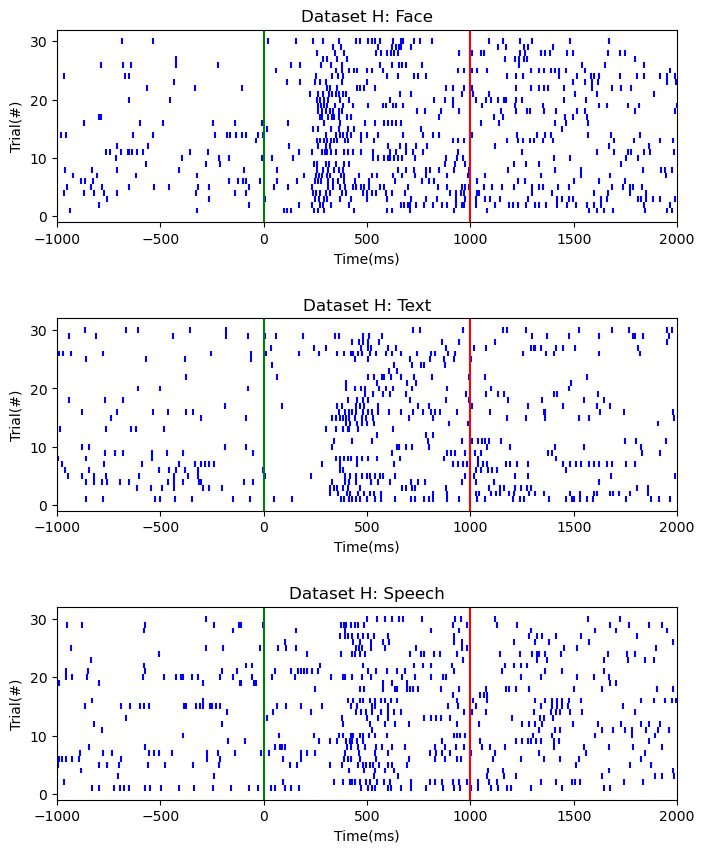

In [361]:
#individual plots for dataset_H

fig_H, axs_H = plt.subplots(3, 1, figsize=(8, 10))
raster(data_H[0], axs_H[0], 'Dataset H: Face')
raster(data_H[1], axs_H[1], 'Dataset H: Text')
raster(data_H[2], axs_H[2], 'Dataset H: Speech')
plt.subplots_adjust(wspace=0.4, hspace=0.5) #just increased spacing between the graphs


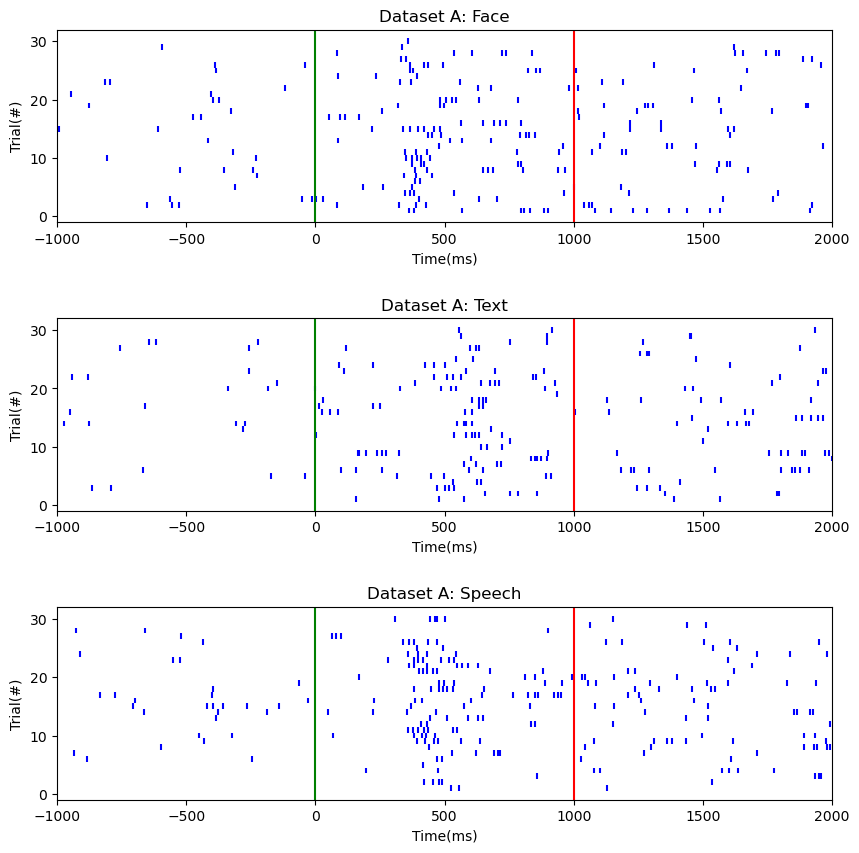

In [362]:

# Create individual plots for dataset_A

fig_A, axs_A = plt.subplots(3, 1, figsize=(10, 10))
raster(data_A[0], axs_A[0], 'Dataset A: Face')
raster(data_A[1], axs_A[1], 'Dataset A: Text')
raster(data_A[2], axs_A[2], 'Dataset A: Speech')
plt.subplots_adjust(wspace=0.4, hspace=0.5) #just increased spacing between the graphs


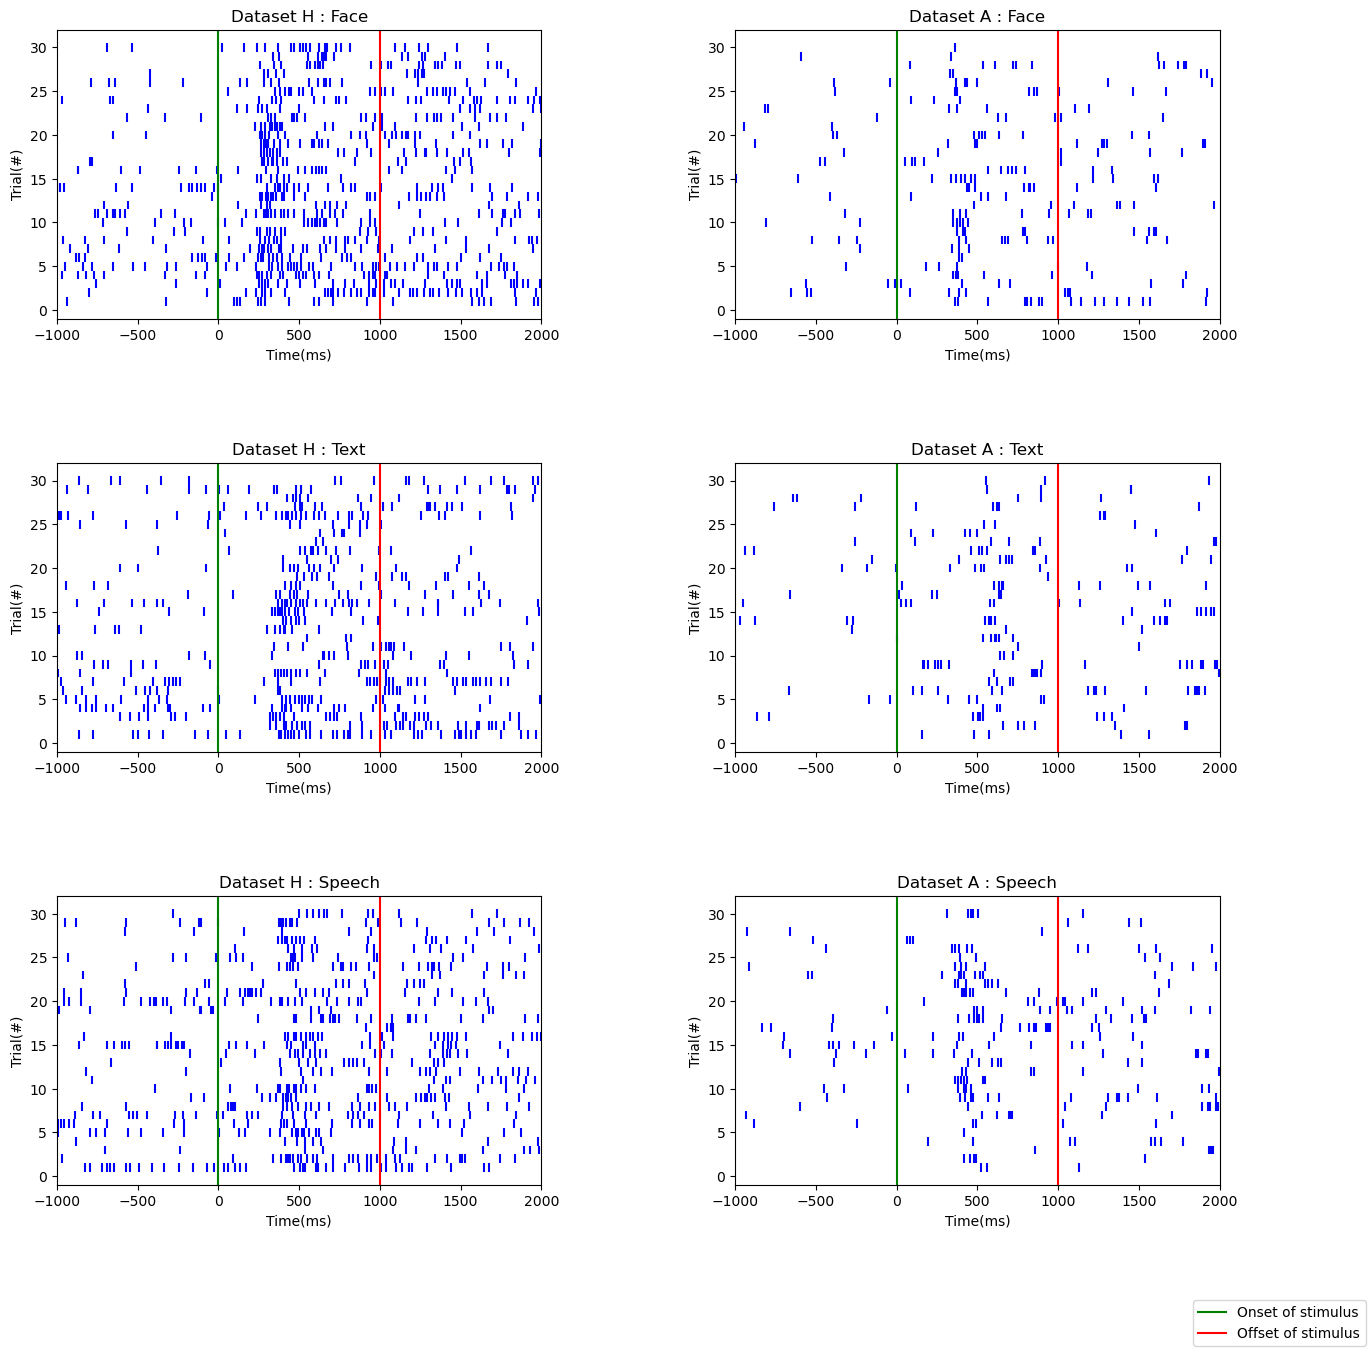

In [363]:
#making the combined plot consisting of 6 plots

fig, axs = plt.subplots(3, 2, figsize=(15,15))

# axs[0, 0].get_shared_y_axes().join(axs[0, 0], axs[1, 0], axs[2, 0])  # Align y-axis for region H plots
raster(data_H[0], axs[0, 0], 'Dataset H : Face')
raster(data_H[1], axs[1, 0], 'Dataset H : Text')
raster(data_H[2], axs[2, 0], 'Dataset H : Speech')

# axs[0, 1].get_shared_y_axes().join(axs[0, 1], axs[1, 1], axs[2, 1])  
raster(data_A[0], axs[0, 1], 'Dataset A : Face')
raster(data_A[1], axs[1, 1], 'Dataset A : Text')
raster(data_A[2], axs[2, 1], 'Dataset A : Speech')

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

plt.subplots_adjust(wspace=0.4, hspace=0.5) #just increased spacing between the combined graphs
plt.show()

## Part B (Peri stimulus Time Plots)

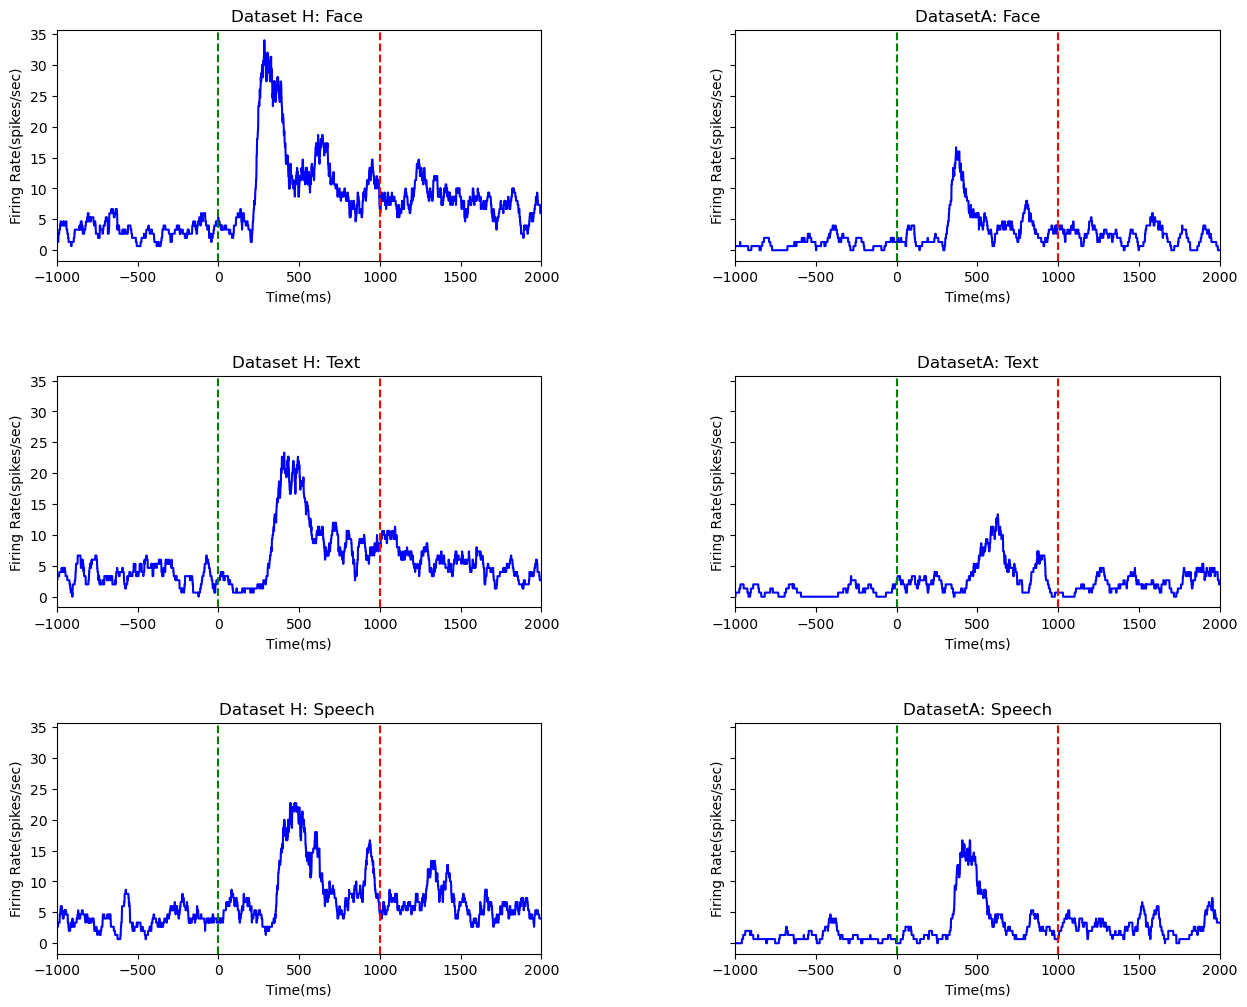

In [364]:
#same approach foollowed as done in part A,
#i.e created a generic function for plotting the peristimulus plots, and 
#later on plotting individual plots and then the combined plots

def peristimulus(spike_times_list, ax, title, bin_width=1, smoothing_window=50, add_legend=False):
    all_spikes = []
    for trial in spike_times_list:
        spike_times_trial = np.squeeze(trial)
        spike_times_trial = np.atleast_1d(spike_times_trial)
        if spike_times_trial.size == 0: #logic followed here is that i've skipped trials with no spikes
            continue  
        all_spikes.extend(spike_times_trial)

    time_range = (-1000, 2000)
    bins = np.arange(time_range[0], time_range[1] + bin_width, bin_width)

    counts, bin_edges = np.histogram(all_spikes, bins=bins)

    firing_rate = counts / len(spike_times_list) * (1000 / bin_width)
    
    
    #as mentioned in teh assignment, using moving 
    #average method to smoothen 
    
    window_size = int(smoothing_window / bin_width)
    window = np.ones(window_size) / window_size
    smoothed_rate = np.convolve(firing_rate, window, mode='same')

    ax.plot(bins[:-1], smoothed_rate, color='blue')
    
    ax.axvline(x=0, color='green', linestyle='--', label='Onset of stimulus')
    ax.axvline(x=1000, color='red', linestyle='--', label='Offset of stimulus')
    
    
    ax.set_xlim([-1000, 2000])
    ax.set_xlabel('Time(ms)')
    ax.set_ylabel('Firing Rate(spikes/sec)')
    
    ax.set_title(title)
    
    if add_legend:
        ax.legend()


fig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=False, sharey=True)


for row, stimulus in enumerate(stimuli):
    ax_H = axs[row, 0] 
    peristimulus(data_H_dict[stimulus], ax_H, f'Dataset H: {stimulus} ', add_legend=add_legend)
    ax_A = axs[row, 1]
    peristimulus(data_A_dict[stimulus], ax_A, f'DatasetA: {stimulus}')

plt.subplots_adjust(wspace=0.4, hspace=0.5) #just increased spacing between the combined graphs
plt.show()


## Part C (Preferred stimulus type of 2 neurons)

Face (12.233 (spikes/second)), Speech (9.467 (spikes/second)), Text (8.533 (spikes/second))
Face (4.067 (spikes/second)), Speech (4.033 (spikes/second)), Text (3.733 (spikes/second))


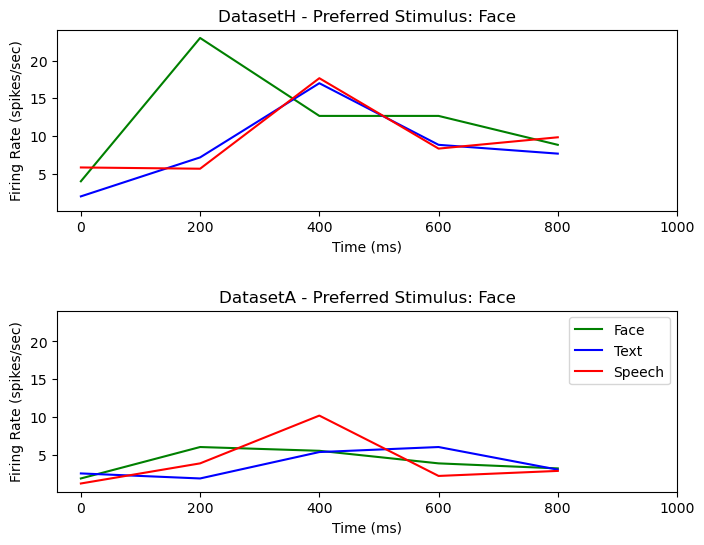

hence we can determine from the statistics that dataset H prefers Face and dataset A prefers Face stimulus


In [407]:
def compute_average_firing_rate(spike_times_list, bins):
    trial_firing_rates = []
    for trial in spike_times_list:
        spike_times_trial = np.squeeze(trial)
        spike_times_trial = np.atleast_1d(spike_times_trial)
        
        
        spikes_in_window = spike_times_trial[(spike_times_trial >= 0) & (spike_times_trial <= 1000)]
        counts, _ = np.histogram(spikes_in_window, bins=bins)
        
        firing_rate = counts * (1000 / (bins[1] - bins[0])) 
        trial_firing_rates.append(firing_rate)
        
    mean_firing_rate = np.mean(trial_firing_rates, axis=0)
    return mean_firing_rate

bin_width = 200#(ms)
bins = np.arange(0, 1000 + bin_width, bin_width)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharey=True)

preferred_stimuli = {}
op = [] # for printing the final answers below
printdictH = {}
printdictA = {}
for idx, (data_dict, region) in enumerate(zip([data_H_dict, data_A_dict], ['H', 'A'])):
    ax = axs[idx]
    mean_firing_rates = {}
    
    for stimulus in stimuli:
    #taking the average over all bins(in the code beloww)
        spike_times_list = data_dict[stimulus]
        
        mean_firing_rate = compute_average_firing_rate(spike_times_list, bins)
        mean_firing_rates[stimulus] = np.mean(mean_firing_rate) 
        
        ax.plot(bins[:-1], mean_firing_rate, color=colors[stimulus], label=stimulus)
    sorted_stimuli = sorted(mean_firing_rates.items(), key=lambda x: x[1], reverse=True) #finding the stimulus preferred in each case
    preferred_stimulus = sorted_stimuli[0][0]
    preferred_stimuli[region] = (preferred_stimulus, sorted_stimuli)


    ax.set_title(f'Dataset{region} - Preferred Stimulus: {preferred_stimulus}')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Firing Rate (spikes/sec)')
    ax.set_xticks(bins)
    
    
    
    order = ', '.join([f'{stimulus} ({round(rate,3)} (spikes/second))' for stimulus, rate in sorted_stimuli])
#     print(f'{stimulus}: {round(rate,3)}')
    first_word = order.split()[0]
    op.append(first_word)
    print(order)

plt.subplots_adjust(wspace=0.4, hspace=.55) #just increased spacing between the combined graphs

ax.legend()

plt.show()

print(f'Hence we can determine from the statistics that dataset H prefers {op[0]} and dataset A prefers {op[1]} stimulus')
